# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link:
https://colab.research.google.com/drive/1B8i7z9lEdfWPrs6McaLNNYsqfRWF6GTl?usp=sharing


In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:03<00:00, 47800169.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

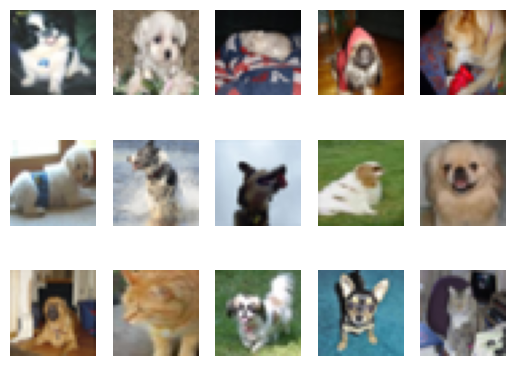

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
num_train = len(train_loader)
num_val = len(val_loader)
num_test = len(test_loader)
print('Number of training examples= ', num_train)
print('Number of validation examples= ', num_val)
print('Number of testing examples= ', num_test)

Number of training examples=  8000
Number of validation examples=  2000
Number of testing examples=  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

####Answer:
Validation Set helps us understand how well the model is performing on unseen data. As the epochs increases, the accuracy of the model on the training set always increases since the weights/hyperparameters have been optimized on the training set. Thus, after a certain number of epochs the accuracy of the model on the training set becomes nearly perfect. However, to understand the model's robustness, we need to see how the model performs on data it hasn't seen before. This is where the validation data set becomes important as it helps us understand how well the model is performing on unseen data resembling real-life scenarios.


If we use the performance of the training loss/error instead of the validation loss/error, we may end up in choosing a model that has overfitting, which means that while it may have a high accuracy, it may not perform well on other data outside of the training set since it has almost memorized the training set data and will not be able to generalize the patterns for the real world data.


## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
count_large = 0
for param in large_net.parameters():
  count_large = count_large + param.numel()
print('Total Number of Parameters: ', count_large)

count_small = 0
for param in small_net.parameters():
  count_small = count_small + param.numel()
print('Total Number of Parameters: ', count_small)

Total Number of Parameters:  9705
Total Number of Parameters:  386


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [7]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

####Answer
Default Values: \\
Batch Size (batch_size)=64 \\
Learning Rate (learning_rate)=0.01 \\
Number of Epochs (num_epochs)=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

### Answer
The files saved on disk are:

1. model_large_bs64_lr0.01_train_err.csv: Contains a numpy array containing the training error on the training data set computed over the 5 epochs.
2. model_large_bs64_lr0.01_train_loss.csv: Contains a numpy array containing the training losses (value of the loss function) on the training data set computed over the 5 epochs.
3. model_large_bs64_lr0.01_val_err.csv: Contains a numpy array containing the validation error on the validation data set computed over the 5 epochs.
4. model_large_bs64_lr0.01_val_loss.csv: Contains a numpy array containing the validation loss (value of the loss function) on the validation data set computed over the 5 epochs.
5. model_large_bs64_lr0.01_epoch0, model_large_bs64_lr0.01_epoch1, model_large_bs64_lr0.01_epoch2, model_large_bs64_lr0.01_epoch3, model_large_bs64_lr0.01_epoch4: Contains the model weights at the end of each epoch.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

### Answer:
Total time elapsed when training large_net = 147.91 seconds
Total time elapsed when training small_net = 136.26 seconds

large_net took longer to train since it has more paramters that need to be optimized.

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.46725, Train loss: 0.6914431228637695 |Validation err: 0.4415, Validation loss: 0.6846812162548304
Epoch 2: Train err: 0.429625, Train loss: 0.6798219680786133 |Validation err: 0.4315, Validation loss: 0.6826168969273567
Epoch 3: Train err: 0.39825, Train loss: 0.6639591064453125 |Validation err: 0.379, Validation loss: 0.6513003949075937
Epoch 4: Train err: 0.3705, Train loss: 0.64355020236969 |Validation err: 0.358, Validation loss: 0.6361154727637768
Epoch 5: Train err: 0.348125, Train loss: 0.6262776761054992 |Validation err: 0.3345, Validation loss: 0.6208219844847918
Epoch 6: Train err: 0.335375, Train loss: 0.60786341381073 |Validation err: 0.3505, Validation loss: 0.6282178442925215
Epoch 7: Train err: 0.31975, Train loss: 0.5965513710975647 |Validation err: 0.322, Validation loss: 0.6005629654973745
Epoch 8: Train err: 0.31075, Train loss: 0.5796730535030366 |Validation err: 0.328

In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.424625, Train loss: 0.6741245946884156 |Validation err: 0.379, Validation loss: 0.6564489062875509
Epoch 2: Train err: 0.363625, Train loss: 0.642889919757843 |Validation err: 0.386, Validation loss: 0.6588546466082335
Epoch 3: Train err: 0.357125, Train loss: 0.6329125423431397 |Validation err: 0.3455, Validation loss: 0.6262651141732931
Epoch 4: Train err: 0.341125, Train loss: 0.620458233833313 |Validation err: 0.3485, Validation loss: 0.617930494248867
Epoch 5: Train err: 0.331375, Train loss: 0.6125331125259399 |Validation err: 0.3395, Validation loss: 0.6135671120136976
Epoch 6: Train err: 0.322375, Train loss: 0.6018698859214783 |Validation err: 0.338, Validation loss: 0.6090283431112766
Epoch 7: Train err: 0.320125, Train loss: 0.5941876366138458 |Validation err: 0.336, Validation loss: 0.5992097482085228
Epoch 8: Train err: 0.308, Train loss: 0.5836592960357666 |Validation err: 0.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
model_path_small = get_model_name(small_net.name, batch_size=64, learning_rate=0.01, epoch=29)
model_path_large = get_model_name(large_net.name, batch_size=64, learning_rate=0.01, epoch=29)

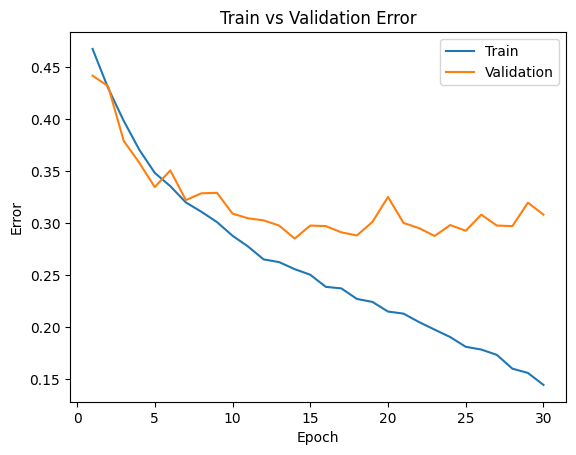

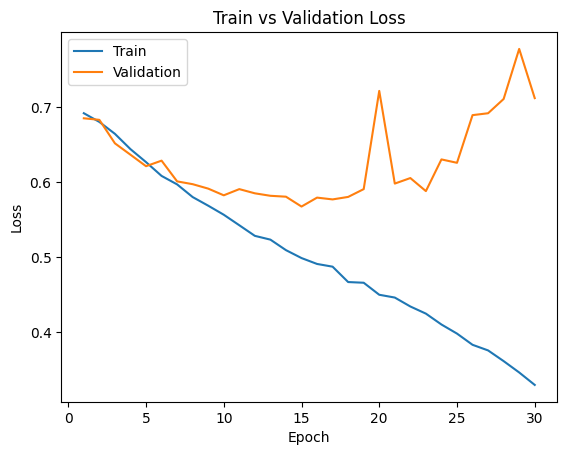

In [ ]:
plot_training_curve(model_path_large)

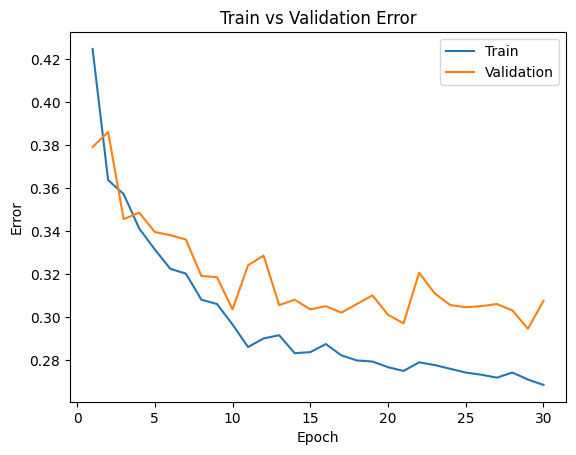

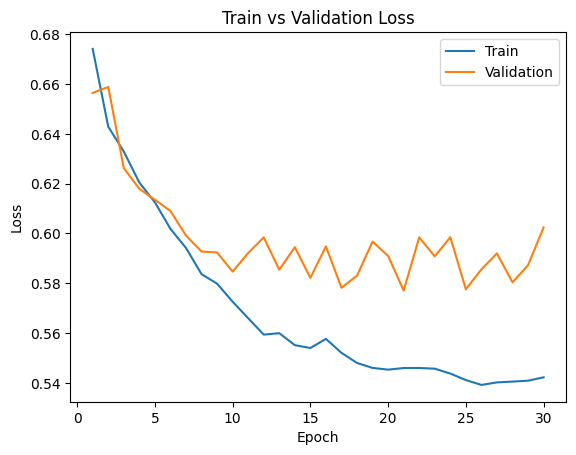

In [ ]:
plot_training_curve(model_path_small)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

#### Answer
LargeNet has Overfitting as clearly the training loss/error decrease over time but the validation loss after initially decreasing starts to increase, while the validation error almost remains constant. This shows that the model has overfitted the training data and is failing to identify generalizing patterns.

SmallNet I think has Underfitting as the Validation and Training Loss do not decrease significantly and almost stabilize, eventually showcasing that the model is too simple to identify complex patterns in the data

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

#### Answer
The model took longer to train (about 148.19 seconds) and this time the validation error/loss also continue to decrease with the training error/loss indicating that our model is beginning to generalize underlying patterns from the training data effectively. It can also be seen that the small learning rate causes the validation error/loss to decrease at an extremely slow rate indicating that this is due to the parameters being optimized by small amounts.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

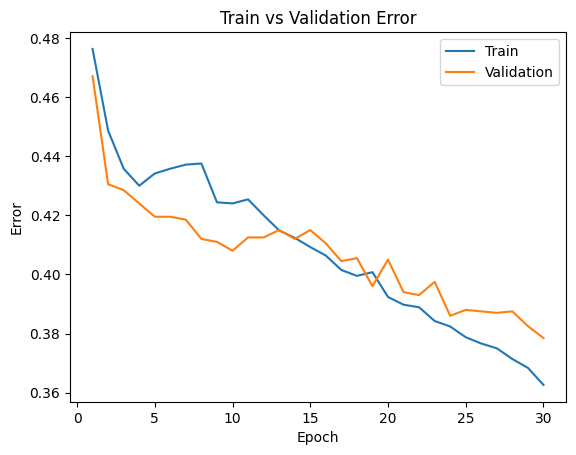

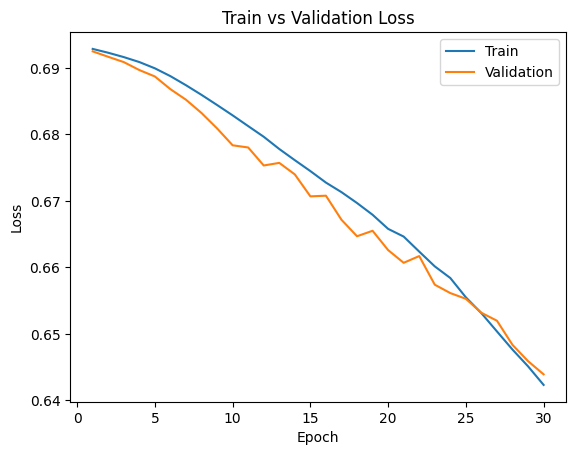

In [ ]:
plot_training_curve(get_model_name(large_net.name, batch_size=64, learning_rate=0.001, epoch=29))

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

#### Answer
The model took longer than the regular version (about 149.04 seconds) since by increasing the learning rate, we are overshooting the optimal parameters, causing the model to overfit (diverge instead of converging at the minimum for the loss function). This is explained by the increasing validation loss.

In [ ]:
large_net_2 = LargeNet()
train_net(large_net_2, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

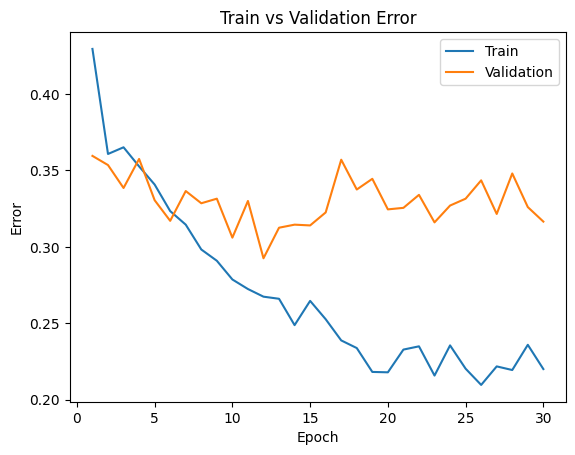

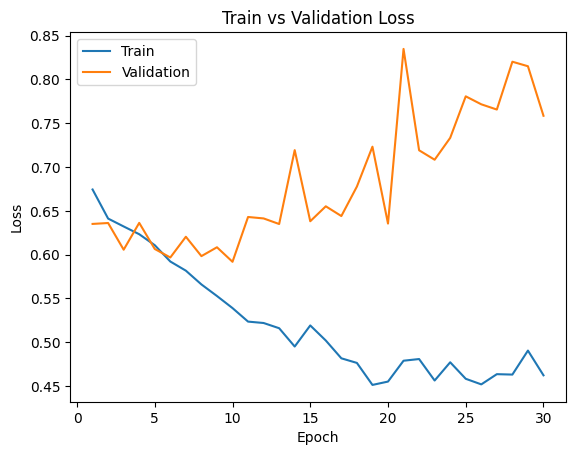

In [ ]:
plot_training_curve(get_model_name(large_net_2.name, batch_size=64, learning_rate=0.1, epoch=29))

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

#### Answer
The model took a shorter time to train (about 131.41 seconds). Moreover, we can also see that the validation loss and error decrease with the epochs and so the model is able to generalize patterns in the data and make better predictions. It can also be noted that due to the large batch size, the errors/losses decrease at a slow rate.

In [ ]:
large_net_3 = LargeNet()
train_net(large_net_3, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

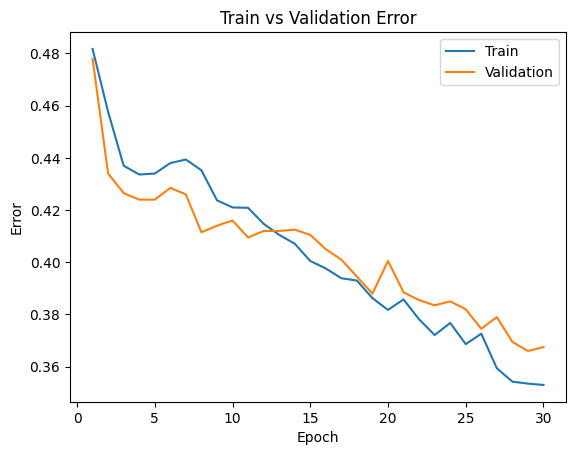

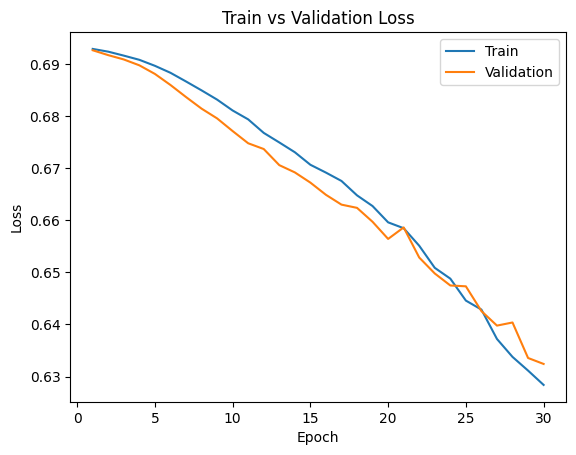

In [ ]:
plot_training_curve(get_model_name(large_net_3.name, batch_size=512, learning_rate=0.01, epoch=29))

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

The model took significantly higher time for training (about 203.78 seconds). Moreover, the set of hyperparameters causes the model to overfit making the validation loss go up significantly. This is probably due to the small batch_size which indicates that the model is memorizing the data rather than finding patterns, causing a overfitting problem.

In [ ]:
large_net_4 = LargeNet()
train_net(large_net_4, batch_size=16, learning_rate=0.01)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43725, Train loss: 0.676032499551773 |Validation err: 0.3785, Validation loss: 0.6522551765441894
Epoch 2: Train err: 0.356125, Train loss: 0.6341751651763916 |Validation err: 0.346, Validation loss: 0.6222775988578796
Epoch 3: Train err: 0.331375, Train loss: 0.6072275066971778 |Validation err: 0.339, Validation loss: 0.6209859902858734
Epoch 4: Train err: 0.305625, Train loss: 0.5809447340965271 |Validation err: 0.3115, Validation loss: 0.592628604888916
Epoch 5: Train err: 0.29125, Train loss: 0.5652809531092644 |Validation err: 0.3045, Validation loss: 0.5863182039260865
Epoch 6: Train err: 0.282625, Train loss: 0.5482984094023704 |Validation err: 0.302, Validation loss: 0.5913978083133697
Epoch 7: Train err: 0.268125, Train loss: 0.5275665176212787 |Validation err: 0.286, Validation loss: 0.5699326264858245
Epoch 8: Train err: 0.253625, Train loss: 0.5076673400700092 |Validation err: 

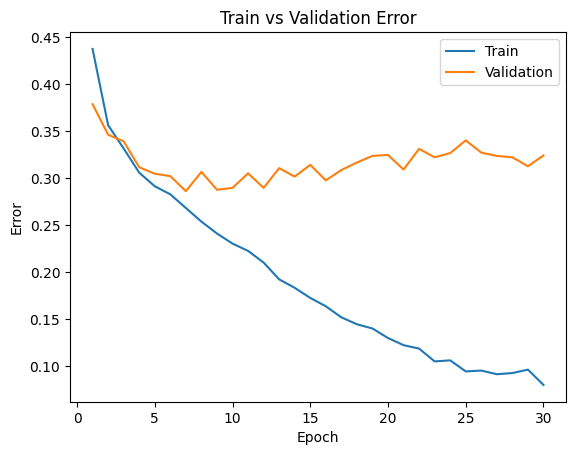

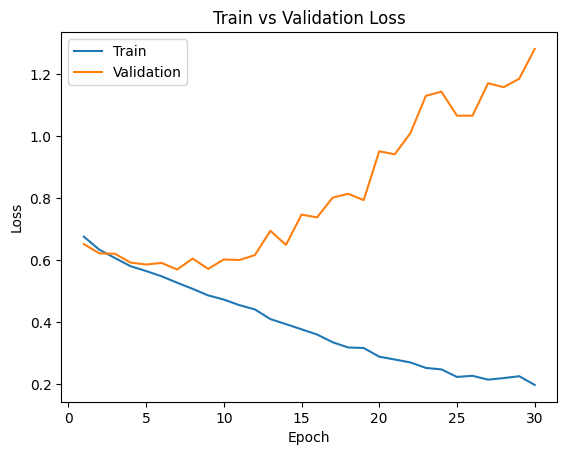

In [ ]:
plot_training_curve(get_model_name(large_net_4.name, batch_size=16, learning_rate=0.01, epoch=29))


## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Since based on the above plots, we can see that increasing the batch size and decreasing the learning rate to an optimal can increase the accuracy of the model, so I tried out to train the large_net model with a batch_size of 256 and learning_rate of 0.005.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net_final = LargeNet()
train_net(large_net_final, learning_rate=0.005, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477625, Train loss: 0.6928693596273661 |Validation err: 0.4685, Validation loss: 0.6925142854452133
Epoch 2: Train err: 0.451125, Train loss: 0.6922451816499233 |Validation err: 0.436, Validation loss: 0.6914755254983902
Epoch 3: Train err: 0.43525, Train loss: 0.6914684548974037 |Validation err: 0.4265, Validation loss: 0.6905745938420296
Epoch 4: Train err: 0.42875, Train loss: 0.6903845928609371 |Validation err: 0.419, Validation loss: 0.6891276985406876
Epoch 5: Train err: 0.43725, Train loss: 0.6891161352396011 |Validation err: 0.4255, Validation loss: 0.6870557442307472
Epoch 6: Train err: 0.435125, Train loss: 0.6875715088099241 |Validation err: 0.423, Validation loss: 0.6847660169005394
Epoch 7: Train err: 0.43575, Train loss: 0.6857213787734509 |Validation err: 0.417, Validation loss: 0.6822805106639862
Epoch 8: Train err: 0.4315, Train loss: 0.6840778402984142 |Validation err: 0.

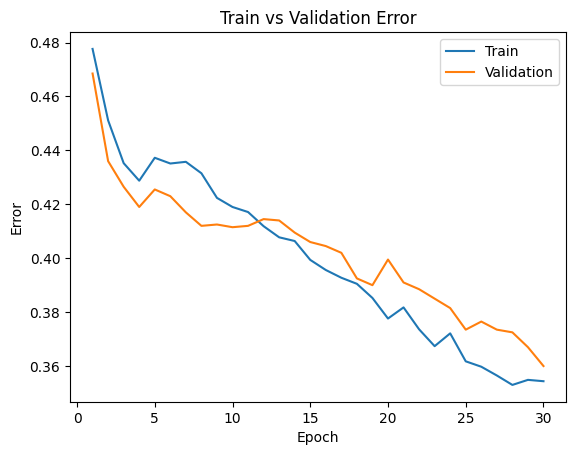

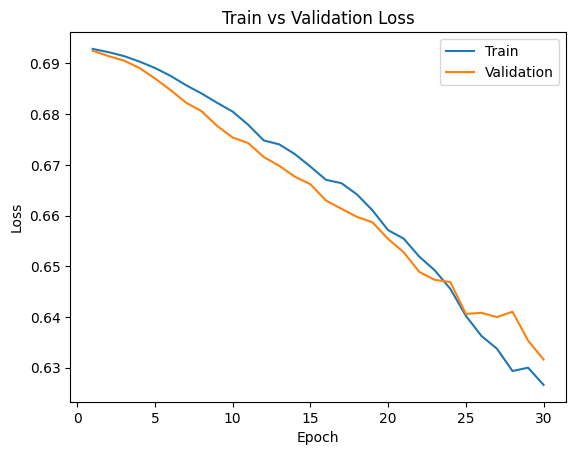

In [ ]:
plot_training_curve(get_model_name(large_net_final.name, batch_size=256, learning_rate=0.005, epoch=29))

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

Based on the above model, we can see that while the error and loss decreased over the epochs, the approach to convergence for the loss function seems to be slow and the updates are extremely small (probably due to a small learning rate and a large batch size). To improve, I further increased the learning rate and decreased batch size to 0.01 and 128 respectively to aim to improve the accuracy.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net_final = LargeNet()
train_net(large_net_final, learning_rate=0.01, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.480125, Train loss: 0.6924600440358358 |Validation err: 0.438, Validation loss: 0.6900788992643356
Epoch 2: Train err: 0.424625, Train loss: 0.6852772169642978 |Validation err: 0.4235, Validation loss: 0.6789555773139
Epoch 3: Train err: 0.415625, Train loss: 0.6756237868278746 |Validation err: 0.4095, Validation loss: 0.6684639267623425
Epoch 4: Train err: 0.396625, Train loss: 0.6677030826371814 |Validation err: 0.386, Validation loss: 0.6601040624082088
Epoch 5: Train err: 0.38725, Train loss: 0.6572725375493368 |Validation err: 0.3725, Validation loss: 0.6496095173060894
Epoch 6: Train err: 0.37175, Train loss: 0.6445890560982719 |Validation err: 0.366, Validation loss: 0.6414701342582703
Epoch 7: Train err: 0.36625, Train loss: 0.6398495804695856 |Validation err: 0.358, Validation loss: 0.6330730728805065
Epoch 8: Train err: 0.352625, Train loss: 0.6286022426590087 |Validation err: 0.

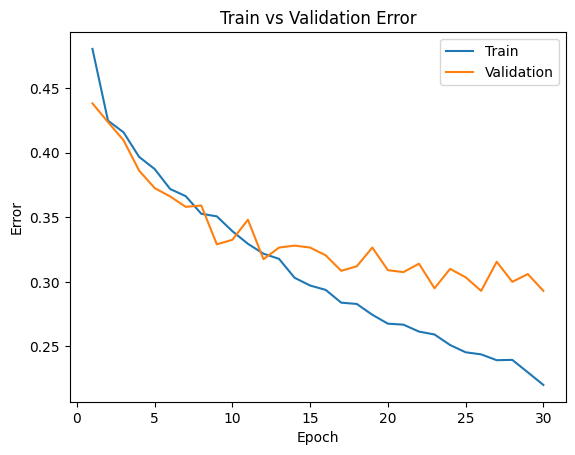

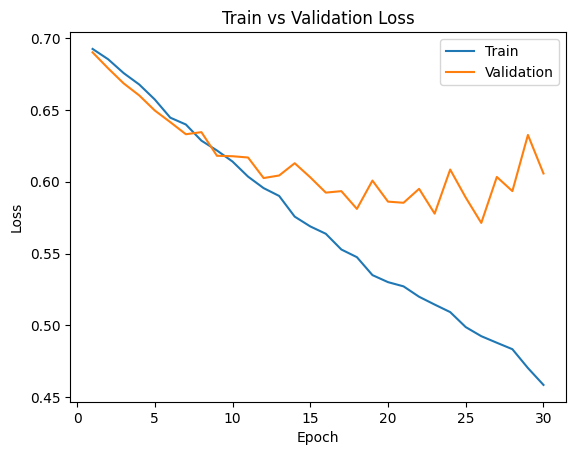

In [ ]:
plot_training_curve(get_model_name(large_net_final.name, batch_size=128, learning_rate=0.01, epoch=29))

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

LargeNet- Able to identify complex patterns in data better than Smallnet (seen in plots above)

Batch_Size of 128- Based on the finetuning done, this is the most optimal. On increasing the batch size, the updates to the loss and error are slow whereas decreasing it causes overfitting.

Learning Rate 0.01- A large learning rate caused overfitting (as seen in the plots) whereas a small learning rate made slow updates to the error/loss. After finetuning, 0.01 turned out to be the most optimal.

Epochs of 30- Optimal no of epochs as less epochs made sure that the minima for loss isnt reached whereas a high number of epochs caused overfitting.

Train Error- 0.22 \\
Test Error- 0.29 \\
Train Loss- 0.45 \\
Test Loss- 0.60

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test error is at 0.2805 and the test loss is at 0.579 and in both cases, the test error and loss are lower than the validation error and loss.

We may expect the test error to be higher since we tune our parameters to fit the validation data. However, this may cause it to overfit the validation data resulting in not being able to generaliza the test data, causing the test error and loss to be higher.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test data is used at the very end as a Final evaluation for our model to see how the model performs on the test data. It is important to use as little as possible of test data since this is only a final evaluation and we want to provide maximmum available data to our model to train on, to enable the highest accuracy and lowest loss for our model (a model that best fits most data). While minimal, it should be a realistic representation of all classes in the data and real world.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

ANN got a final test error of about 36% compared with the 28% error for the CNN. CNN outperforms ANN.

In [9]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(torch.squeeze(outputs, 1), labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [11]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


In [15]:
class ANN(nn.Module):
  def __init__(self):
    super(ANN, self).__init__()
    self.name='ann'
    self.fc1 = nn.Linear(32 * 32 * 3, 50)
    self.fc2 = nn.Linear(50, 20)
    self.fc3 = nn.Linear(20, 1)

  def forward(self, img):
    flattened = img.view(-1, 32 * 32 * 3)
    activation1 = F.relu(self.fc1(flattened))
    activation2 = F.relu(self.fc2(activation1))
    output = self.fc3(activation2)
    return output.view(-1, 1)

In [16]:
model = ANN()

In [17]:
train_net(model)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4215, Train loss: 0.672253755569458 |Validation err: 0.4045, Validation loss: 0.6574965268373489
Epoch 2: Train err: 0.38475, Train loss: 0.6448594288825988 |Validation err: 0.395, Validation loss: 0.6554584875702858
Epoch 3: Train err: 0.3595, Train loss: 0.6326253395080567 |Validation err: 0.3855, Validation loss: 0.642657058313489
Epoch 4: Train err: 0.34625, Train loss: 0.6200131397247315 |Validation err: 0.4095, Validation loss: 0.6673404816538095
Epoch 5: Train err: 0.335125, Train loss: 0.6089990487098694 |Validation err: 0.3725, Validation loss: 0.6428382061421871
Epoch 6: Train err: 0.321375, Train loss: 0.5951425888538361 |Validation err: 0.3675, Validation loss: 0.6399769634008408
Epoch 7: Train err: 0.306625, Train loss: 0.5793783092498779 |Validation err: 0.3625, Validation loss: 0.648040633648634
Epoch 8: Train err: 0.28675, Train loss: 0.5604229438304901 |Validation err: 0.3

In [18]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)
ann_err, ann_loss = evaluate(model, test_loader, nn.BCEWithLogitsLoss())
print('ANN Error=', ann_err)

Files already downloaded and verified
Files already downloaded and verified
ANN Error= 0.3595


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)
test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('Test Error ', test_err)
print('Test Loss ', test_loss)


Test Error  0.2805
Test Loss  0.579434571787715
